In [1]:
import torch
from utils import data_loader
from mnist_classifier import NeuralModel
import mnist_classifier
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
from vae_models import VAE_CONV_NeuralModel
from utils.viewer import show_batch

In [2]:
train_set, test_set = data_loader.get_data()
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
classification_model = NeuralModel()
classification_model.to(device)
classification_model.load_state_dict(torch.load("models/trained_model"))
classification_model.eval()

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []


In [5]:
batch_size = 512
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

clean_accuracies = []
vae = VAE_CONV_NeuralModel()
for Beta in range (1,11):
    vae.load_state_dict(torch.load("models/trained_CONV_vae_B="+str(Beta)))
    vae.to(device)

    acc_sum = 0
    for batch in test_loader:

        batch_images, batch_labels = batch
        recs, _, _ = vae(batch_images.to(device))

        reconstructed_batch = (recs, batch_labels.to(device))
        acc = mnist_classifier.test_model(classification_model, reconstructed_batch)
        acc_sum += acc

    clean_accuracies.append(acc_sum)


In [6]:
for eps in epsilons: 
    path = 'models/adversarial_examples/adversarial_examples_epsilon='+str(eps)+'_.pkl'
    per_epsilon_accuracies = []
    with open(path, 'rb') as f:
        examples_set = pickle.load(f)
        
        true_labels = []
        adv_labels = []
        adv_examples = []

        for example in examples_set:
            true_label, adv_label, adv_example = example

            true_labels.append(true_label)
            adv_labels.append(adv_label)
            adv_examples.append(adv_example)

        true_labels = torch.Tensor(true_labels).long().to(device)
        adv_examples = torch.Tensor(adv_examples)
        b_size, w, h = adv_examples.shape
        adv_examples = adv_examples.reshape(b_size, 1, w, h)
        adv_examples = adv_examples.to(device)

        vae = VAE_CONV_NeuralModel()
        for Beta in range (1,11):
            vae.load_state_dict(torch.load("models/trained_CONV_vae_B="+str(Beta)))
            vae.to(device)

            recs, _, _ = vae(adv_examples)
            recs = recs.reshape(-1, 1, 28, 28)
            reconstructed_data = (recs, true_labels)

            acc = mnist_classifier.test_model(classification_model, reconstructed_data)

            per_epsilon_accuracies.append(acc)
        
        accuracies.append(per_epsilon_accuracies)
        

(7, 10)


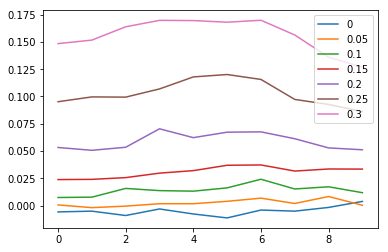

In [9]:
accuracies = np.array(accuracies)
clean_accuracies = np.array(clean_accuracies).reshape(1,-1)
print(accuracies.shape)

accuracies_diff = clean_accuracies - accuracies

for eps, per_epsilon_diff in zip(epsilons,accuracies_diff):
    plt.plot(per_epsilon_diff, label =str(eps))
plt.legend()